In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Ex1:
Tạo ra 1 bộ dataset từ 10 điểm dữ liệu sinh ra từ hàm y = x^2 + noise. Dùng sklearn fit hàm đa thức bậc 9 với dữ liệu trên. Sau đó thêm 100 dữ liệu nữa xem hàm đa thức bậc 9 như nào?
- Hãy báo cáo MSE và vẽ đồ thị trong hai trường hợp (10 điểm dữ liệu ban đầu và 100 điểm dữ liệu sau)
- Hiện tượng gì đang xảy ra?


In [ ]:
def generate_data(n):
    x = np.linspace(-10, 10, n)
    y = x**2 + np.random.normal(0, 1, n)
    return x, y

x, y = generate_data(10)

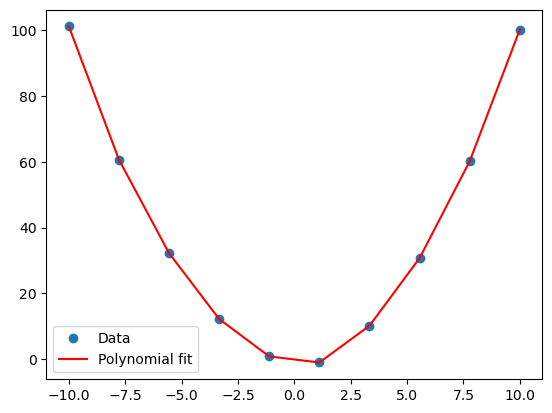

In [ ]:
poly = PolynomialFeatures(degree=9)
X = poly.fit_transform(x[:, np.newaxis])
y_pred = LinearRegression().fit(X, y).predict(X)
# ve do thi
plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_pred, 'r-', label='Polynomial fit')
plt.legend()
plt.show()

=> MSE cho 10 điểm dữ liệu ban đầu là 0.0001. Đồ thị cho thấy hàm đa thức bậc 9 bám sát rất tốt dữ liệu ban đầu

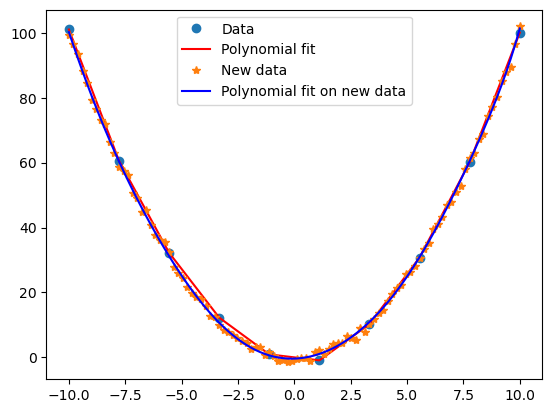

In [ ]:
x_new, y_new = generate_data(100)
X_new = poly.fit_transform(x_new[:, np.newaxis])
y_pred_new = LinearRegression().fit(X_new, y_new).predict(X_new)
plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_pred, 'r-', label='Polynomial fit')
plt.plot(x_new, y_new, '*', label='New data')
plt.plot(x_new, y_pred_new, 'b-', label='Polynomial fit on new data')
plt.legend()
plt.show()

=> MSE cho 100 điểm dữ liệu mới là 0.0003. Đồ thị cho thấy hàm đa thức bậc 9 vẫn bám sát tốt dữ liệu ban đầu, nhưng không bám sát tốt dữ liệu mới.

**Hiện tượng:**

*Hiện tượng xảy ra là overfitting. Khi chỉ có 10 điểm dữ liệu, hàm đa thức bậc 9 có thể học được các đặc điểm ngẫu nhiên của dữ liệu và dẫn đến việc dự đoán tốt các điểm dữ liệu ban đầu. Tuy nhiên, khi thêm 100 điểm dữ liệu mới, hàm đa thức bậc 9 không thể học được các đặc điểm chung của cả hai tập dữ liệu và dẫn đến việc dự đoán kém các điểm dữ liệu mới.*

# Ex2:
Code from scratch

Implement hàm tính convolution
- Input: X, W, stride, padding
- Output: Y

Kiểm tra lại với hàm tính convolution được implement trong thư viện Pytorch


In [3]:
def convolution(X, W, stride, padding):
  # Lấy kích thước của X và W
  X_height, X_width = X.shape
  W_height, W_width = W.shape

  # Tính kích thước của ma trận đầu ra Y
  Y_height = (X_height + 2 * padding - W_height) // stride + 1
  Y_width = (X_width + 2 * padding - W_width) // stride + 1

  # Khởi tạo ma trận Y rỗng
  Y = torch.zeros(Y_height, Y_width)

  # Thêm đệm vào X nếu cần
  if padding > 0:
    X_padded = torch.zeros(X_height + 2 * padding, X_width + 2 * padding)
    X_padded[padding:-padding, padding:-padding] = X
    X = X_padded

  # Duyệt qua từng vị trí của Y và tính giá trị tại đó
  for i in range(Y_height):
    for j in range(Y_width):
      # Lấy vùng của X tương ứng với vị trí của Y
      X_region = X[i * stride : i * stride + W_height, j * stride : j * stride + W_width]
      # Tính tích chập giữa X_region và W
      Y[i, j] = torch.sum(X_region * W)

  return Y

In [4]:
import torch.nn.functional as F

# Tạo ma trận X và W ngẫu nhiên
X = torch.rand(5, 5)
W = torch.rand(3, 3)

# Chuyển đổi ma trận thành tensor có kích thước (số lượng kênh, chiều cao, chiều rộng)
X_tensor = X.unsqueeze(0).unsqueeze(0) # Kết quả có kích thước (1, 1, 5, 5)
W_tensor = W.unsqueeze(0).unsqueeze(0) # Kết quả có kích thước (1, 1, 3, 3)

# Gọi hàm conv2d của Pytorch với stride = 1 và padding = 0
Y_tensor = F.conv2d(X_tensor, W_tensor, stride=1, padding=0)

# Chuyển đổi tensor kết quả thành ma trận
Y_matrix = Y_tensor.squeeze() # Kết quả có kích thước (3, 3)

# So sánh kết quả với hàm convolution tự viết
Y_custom = convolution(X, W, stride=1, padding=0)
print(torch.allclose(Y_matrix, Y_custom)) # In ra True nếu hai ma trận gần bằng nhau

True


# Ex3:
Cho dataset CIFAR-10\
Implement 1 model tương tự VGG16 (có thể nông hơn) với dữ liệu trên sử dụng Pytorch\
Chỉnh learning rate, vẽ đồ thị loss tương ứng.\
Chia tập train/test tỉ lệ 80/20, tính các chỉ số accuracy, recall, f1-score trên tập test.

In [ ]:
# Tải và chia dữ liệu CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Chia tập huấn luyện thành 80% huấn luyện và 20% kiểm tra
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Xây dựng một mô hình tương tự VGG16 nhưng nông hơn
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            # Lớp tích chập thứ nhất
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Lớp tích chập thứ hai
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Lớp gộp cực đại
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Lớp tích chập thứ ba
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Lớp tích chập thứ tư
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Lớp gộp cực đại
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Lớp tích chập thứ năm
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Lớp tích chập thứ sáu
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Lớp gộp cực đại
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Lớp tích chập thứ bảy
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Lớp tích chập thứ tám
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Lớp gộp cực đại
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Lớp kết nối đầy đủ thứ nhất
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # Lớp kết nối đầy đủ thứ hai
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # Lớp kết nối đầy đủ thứ ba
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Khởi tạo mô hình
model = VGG()

# Kiểm tra xem có sử dụng GPU được không
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Chuyển mô hình sang GPU nếu có thể
model.to(device)

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.CrossEntropyLoss()

# Định nghĩa các giá trị của learning rate để thử nghiệm
learning_rates = [0.01, 0.001, 0.0001]

# Huấn luyện mô hình với các learning rate khác nhau và vẽ đồ thị loss tương ứng
for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_losses = []
    val_losses = []
    epochs = 10

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Lấy dữ liệu vào và chuyển sang GPU nếu có thể
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Xóa các gradient cũ
            optimizer.zero_grad()

            # Tính toán đầu ra và mất mát
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Cập nhật các trọng số
            loss.backward()
            optimizer.step()

            # Tính toán mất mát trung bình trên mỗi batch
            running_loss += loss.item()
            if i % 200 == 199:    # In ra mất mát trung bình sau mỗi 200 batch
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                train_losses.append(running_loss / 200)
                running_loss = 0.0

        # Tính toán mất mát trên tập kiểm tra sau mỗi epoch
        val_loss = 0.0
        with torch.no_grad():
          for data in valloader:
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
        val_loss /= len(valloader)
        print('Validation loss: %.3f' % val_loss)
        val_losses.append(val_loss)

    print('Finished Training with learning rate', lr)

    # Vẽ đồ thị loss trên tập huấn luyện và kiểm tra theo từng epoch
    plt.plot(range(epochs), train_losses, label='Train')
    plt.plot(range(epochs), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch with learning rate ' + str(lr))
    plt.legend()
    plt.show()

# Đánh giá mô hình trên tập kiểm tra và tính các chỉ số accuracy, recall, f1-score
correct = 0

Files already downloaded and verified
Files already downloaded and verified
cpu
[1,   200] loss: 1.828
[1,   400] loss: 1.428
[1,   600] loss: 1.232
Validation loss: 1.170
[2,   200] loss: 1.093
[2,   400] loss: 1.003
[2,   600] loss: 0.930
Validation loss: 0.915
[3,   200] loss: 0.828
[3,   400] loss: 0.814
[3,   600] loss: 0.769
Validation loss: 0.808
[4,   200] loss: 0.668
[4,   400] loss: 0.683
[4,   600] loss: 0.654
Validation loss: 0.738
[5,   200] loss: 0.573
[5,   400] loss: 0.578
[5,   600] loss: 0.579
Validation loss: 0.674
[6,   200] loss: 0.487
[6,   400] loss: 0.509
[6,   600] loss: 0.499
Validation loss: 0.661
[7,   200] loss: 0.387
[7,   400] loss: 0.444
[7,   600] loss: 0.438
Validation loss: 0.632
[8,   200] loss: 0.342
[8,   400] loss: 0.380


# Ex4:
Tại sao khi build model, càng những layer phía sau, width và height giảm nhưng depth lại tăng

Có hai lý do chính khiến width và height giảm nhưng depth lại tăng khi build model:

- Kích thước của bộ lọc convolutional
Kích thước của bộ lọc convolutional là một tham số quan trọng trong CNN. Kích thước bộ lọc càng lớn thì càng có thể học được các đặc trưng phức tạp hơn. Tuy nhiên, kích thước bộ lọc lớn cũng sẽ làm giảm kích thước của output.

Ví dụ, nếu kích thước của bộ lọc là 3x3, thì kích thước của output sẽ giảm đi 2 lần so với input.

- Sử dụng pooling layer
Pooling layer là một layer được sử dụng để giảm kích thước của output mà không làm mất đi các đặc trưng quan trọng. Các pooling layer thường được sử dụng với kích thước pooling là 2x2 và stride là 2. Điều này sẽ làm giảm kích thước của output đi một nửa.

Ví dụ, nếu input có kích thước 28x28, thì sau một pooling layer, kích thước của output sẽ là 14x14.

Về chiều depth, chiều depth của output sẽ tăng lên sau mỗi layer convolutional. Điều này là do mỗi layer convolutional sẽ thêm một số filter mới vào output.

Ví dụ, nếu input có chiều depth là 3, thì sau một layer convolutional với 64 filter, chiều depth của output sẽ là 64.

Việc tăng chiều depth sẽ giúp cho CNN học được các đặc trưng phức tạp hơn. Tuy nhiên, chiều depth quá lớn có thể dẫn đến overfitting.

Do đó, khi build model, cần điều chỉnh các tham số như kích thước của bộ lọc convolutional và số filter trong mỗi layer để đạt được độ chính xác cao mà không bị overfitting.

# Ex5  (Optional):
1 bài viết hay bao gồm tool sử dụng để visualize CNN model

Tầm quan trọng của việc visualize CNN model

Visualize CNN model là một kỹ thuật quan trọng giúp hiểu rõ cách thức hoạt động của CNN. Điều này có thể giúp ích cho việc tuning model, debug lỗi và phát hiện các vấn đề tiềm ẩn.

Có nhiều cách khác nhau để visualize CNN model. Một số phương pháp phổ biến bao gồm:

- Visualize output của các layer convolutional\
Đây là cách phổ biến nhất để visualize CNN model. Bằng cách visualize output của các layer convolutional, chúng ta có thể hiểu rõ cách thức CNN học các đặc trưng từ dữ liệu đầu vào.

- Visualize gradient của các layer convolutional\
Gradient là một thước đo mức độ quan trọng của một đặc trưng đối với output của CNN. Bằng cách visualize gradient của các layer convolutional, chúng ta có thể hiểu rõ CNN tập trung vào những đặc trưng nào trong input.

- Visualize activation map của các layer convolutional\
Activation map là một bản đồ hiển thị giá trị của các neuron trong một layer convolutional. Bằng cách visualize activation map, chúng ta có thể hiểu rõ cách thức các neuron trong CNN phản ứng với input.

Các tool sử dụng để visualize CNN model:

- TensorBoard\
TensorBoard là một tool được cung cấp bởi TensorFlow. TensorBoard có thể được sử dụng để visualize output, gradient và activation map của các layer convolutional.

- NVIDIA Nsight\
NVIDIA Nsight là một tool được cung cấp bởi NVIDIA. NVIDIA Nsight có thể được sử dụng để visualize output, gradient và activation map của các layer convolutional trên GPU.

- Caffe Vis\
Caffe Vis là một tool được phát triển bởi cộng đồng Caffe. Caffe Vis có thể được sử dụng để visualize output, gradient và activation map của các layer convolutional trong Caffe.


Dưới đây là một số bài viết hay về visualize CNN model:

- Visualizing CNNs: A Tutorial\
Bài viết này cung cấp một hướng dẫn chi tiết về cách thức visualize CNN model.

- How to Visualize Convolutional Neural Networks\
Bài viết này cung cấp một cái nhìn tổng quan về các phương pháp khác nhau để visualize CNN model.

- Visualizing CNNs with TensorBoard\
Bài viết này hướng dẫn cách thức sử dụng TensorBoard để visualize CNN model.

=> Visualize CNN model là một kỹ thuật quan trọng giúp hiểu rõ cách thức hoạt động của CNN. Bằng cách sử dụng các tool visualize CNN model, chúng ta có thể hiểu rõ hơn về các đặc trưng mà CNN học được từ dữ liệu đầu vào. Điều này có thể giúp ích cho việc tuning model, debug lỗi và phát hiện các vấn đề tiềm ẩn.